In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, clear_output, Audio
%matplotlib inline
# %matplotlib widget
plt.rcParams['figure.dpi']= 150

# Inner medulla with VRI
A recent preliminary finding by Alan Weinstein on red blood cells suggest that, instead of salt dump, we should have red blood cells soak up water by taking in potassium from the collecting tubule.
Apparently, regulatory volume increase (RVI) of red blood cells, which counteracts the osmotically induced cell shrinkage in the inner medulla, is responsible for the potassium reuptake.
Hence, we discard the idea of salt dump and introduce a new scheme in which a new salt species (representing K+ and its anion pair) is reabsorbed from the collecting tubule at a constant rate.

## Parameters

The equations stay the same except a few additional terms on the right-hand side of water flow equations in the central core and the collecting tubule.
We also have two new parameters: the initial potassium flow and the rate of potassium reabsorption, which mimics the RVI.

We first assign a value to each parameter.
This is referenced from Stephenson's paper (2 nephrons).

In [204]:
# Geometric parameters
L = 0.6 # cm
c_star = 0.294 # mmol/mL
RT = 19344 # mmHg.mL/mmol
rad_0 = 0.0025 # cm
rad_D = 0.0008 # cm
rad_A = 0.001 # cm
rad_C = 0.0012 # cm
area_0 = np.pi*rad_0**2 # cm^2
area_D = np.pi*rad_D**2 # cm^2
area_A = np.pi*rad_A**2 # cm^2
area_C = np.pi*rad_C**2 # cm^2
# area_tot = (area_0 + area_D + area_A + area_C)/4 # cm^2
area_tot = np.min([area_0, area_D, area_A, area_C]) # cm^2
# circ_0 = 2*np.pi*rad_0 # cm
circ_D = 2*np.pi*rad_D # cm
circ_A = 2*np.pi*rad_A # cm
circ_C = 2*np.pi*rad_C # cm
pressure = c_star*RT/500
hydr_resist = 8*0.6915*np.pi*(0.0075*10**(-3)) # mmHg.s (take \eta=0.6915 cP)
# rho_interst = 8*3.5*np.pi*(0.0075*10**(-3)) # mmHg.s
# hydr_resist = rho_interst
tau = hydr_resist*L**2/(area_tot*pressure)

# Transport parameters
exag = 30
s_perm = 26e-5 # cm/s
u_perm_val = 1.5e-5 # cm/s
w_D_perm = exag*20.4e-5/760 # cm/mmHg.s
w_C_perm = exag*3e-5/760 # cm/mmHg.s
F_PCT = 0.167e-6 # cm^3/s
osm_input = 0.5885 # mmol/cm^3
p_in = 0.058 # mmol/cm^3
u_in = 0.2392 # mmol/cm^3

long_loops = 0.5
Q_D_input = long_loops*0.45*F_PCT*tau/(area_tot*L)
Q_C_input = 0.15*F_PCT*tau/(area_tot*L)
osm_input = osm_input/c_star
p_in = p_in/c_star
u_in = u_in/c_star
S_input = Q_D_input*osm_input/2 # mmol/s
P_input = Q_C_input*p_in # mmol/s
U_input = Q_C_input*(osm_input - 2*p_in)
# U_input = Q_C_input*u_in
N_input = Q_C_input*(osm_input - 2*p_in) - U_input
u_frac = 1
p_rate = 0

s_perm = s_perm*circ_A*tau/(area_tot)
u_perm_val = u_perm_val*circ_C*tau/(area_tot)
w_D_perm = w_D_perm*circ_D*pressure*tau/area_tot
w_C_perm = w_C_perm*circ_C*pressure*tau/area_tot

In [186]:
# calculate dimensionless diffusion coefficient
# 1.5e-5*tau/L**2
# 0.00025*tau/L**2
# 2*S_input/Q_D_input - (U_input+2*P_input)/Q_C_input
(s_perm,u_perm_val,w_D_perm,w_C_perm,S_input,U_input,P_input,p_rate,tau,pressure,0.00025*tau/L**2,1.5e-5*tau/L**2)

(1.6671156239713627,
 0.11541569704417128,
 1.566111019736842,
 0.345465666118421,
 0.0639630825415584,
 0.06847364826029191,
 0.008405230897559643,
 0,
 2.0518346141186004,
 11.374272,
 0.0014248851486934725,
 8.549310892160835e-05)

Note that, in the advection timescale, normalizing the pressure (taking the typical magnitude to be $\approx 10$ mmHg which is around $\approx 500$ times $c_*RT$) allows us to ignore the effect of hydrostatic pressure on the transmural fluxes; this is in agreement of the model assumption.

Since the non-dimensionalized parameters are quite different from the toy parameters that we previously used (namely, the flows and water permeability are much smaller), we will later use dynamical simulation to find a suitable initial condition to compute the steady state solutions.

For now, we will use the toy parameters as before.

In [4]:
# Transport parameters
s_perm = 1.2
u_perm_val = 1.2
w_D_perm = 10
w_C_perm = 10
S_input = 0.8
P_input = 2*(P_input/U_input)
U_input = 2 - P_input
osm_input = 2
Q_D_input = 2*S_input/osm_input
Q_C_input = (U_input + 2*P_input)/osm_input
u_frac = 1
(s_perm,u_perm_val,w_D_perm,w_C_perm,S_input,U_input,P_input,p_rate,tau,pressure,0.00025*tau/L**2)

(1.2,
 1.2,
 10,
 10,
 0.8,
 1.7544973544973546,
 0.24550264550264553,
 0,
 8.952130534512609,
 11.374272,
 0.006216757315633756)

## Steady state solution
First, we'll try to compute a steady state solution.
We start with discretization and defining the finite difference operator.

In [205]:
# discretization
N = 50
dx = 1/N
u_perm = np.zeros(N)
for l in range(N):
    perm_grids = u_frac*N
    insul = np.floor(N-perm_grids)
    if l==insul:
        u_perm[l] = u_perm_val*(perm_grids - np.ceil(perm_grids-1))
    elif l>insul:
        u_perm[l] = u_perm_val

def diff_x(y): 
    n = len(y)-1
    diff = np.zeros(n)
    for l in range(n):
        diff[l] = (y[l+1]-y[l])/dx
    
    return diff

def avg(y):
    n = len(y)-1
    average = np.zeros(n)
    for l in range(n):
        average[l] = (y[l+1]+y[l])/2
    
    return average

Since we assume that potassium is reabsorbed at a constant rate, we can define a function to compute the potassium flow in collecting tubule and the central core.

In [4]:
def p_flow(k='C',rho=p_rate,average=True):
    flow = np.zeros(N+1)
    r = np.zeros(N+1)
    # r[:] = rho
    for l in range(N):
        perm_grids = u_frac*N
        insul = np.floor(N-perm_grids)
        if l==insul:
            r[l] = rho*(perm_grids - np.ceil(perm_grids-1))
        elif l>insul:
            r[l] = rho
    # if average:
    #     if k=='C':
    #         for l in range(N):
    #             flow[l] = P_input - r[l]*((l+1/2)*dx)
    #     elif k==0:
    #         for l in range(N):
    #             flow[l] = r[l]*((l+1/2)*dx - 1)
    # else:
    flow = np.zeros(N+1)
    # if k=='C':
    #     for l in range(N+1):
    #         flow[l] = P_input - r[l]*(l*dx)
    # elif k==0:
    #     for l in range(N+1):
    #         flow[l] = r[l]*(l*dx - 1)
    if k=='C':
        flow[0] = P_input
        for l in range(N):
            flow[l+1] = flow[l] - r[l]*dx
    elif k==0:
        flow[-1] = 0
        for l in range(N):
            flow[N-l-1] = flow[N-l] - r[N-l-1]*dx

    if average:
        flow = avg(flow)
    
    return flow

Then, we define the residue to implicitly solve the steady state.

In [5]:
def res(y,y_prev=None,h=0,rho=0):
    S = y[:(N+1)].copy()
    U = y[(N+1):2*(N+1)].copy()
    q_D = y[2*(N+1):3*(N+1)].copy()
    q_C = y[3*(N+1):4*(N+1)].copy()
    q_A = y[4*(N+1):5*(N+1)].copy()
    q_out = y[5*(N+1):6*(N+1)].copy()
    rvi = y[6*(N+1)]
    S_avg = avg(S)
    U_avg = avg(U)
    q_D_avg = avg(q_D)
    q_C_avg = avg(q_C)
    q_A_avg = avg(q_A)
    # q_out_avg = avg(q_out)

    S_0 = S[-1] - S_avg
    U_0 = U[-1] - U_avg
    # q_0 = q_out_avg - q_C_avg - q_A_avg - q_D_avg
    q_0 = np.zeros(N+1)
    q_0[:-1] = q_out[:-1] - q_C[:-1] - q_A[:-1] - q_D[:-1]
    # q_0 = q_out - q_C - q_A - q_D
    q_0_avg = avg(q_0)

    P_C = np.zeros(N)
    P_0 = np.zeros(N)
    if h>0:
        P_C = p_flow('C',rvi)
        P_0 = p_flow(0,rvi)
    else:
        P_C = p_flow('C',rho)
        P_0 = p_flow(0,rho)

    residue = np.zeros(6*N+7)
    res_s = residue[:(N+1)]
    res_u = residue[(N+1):2*(N+1)]
    res_D = residue[2*(N+1):3*(N+1)]
    res_C = residue[3*(N+1):4*(N+1)]
    res_A = residue[4*(N+1):5*(N+1)]
    res_out = residue[5*(N+1):6*(N+1)]
    res_dump = residue[6*(N+1):]

    res_s[0] = S[-1] + S_input
    res_s[1:] = diff_x(S) + s_perm*(
        # (S_avg/q_A_avg) - (S_0/q_0)
        (S_avg/q_A_avg) - (S_0/q_0_avg)
    )
    res_u[0] = U[0] - U_input
    res_u[1:] = diff_x(U) + u_perm*(
        # (U_avg/q_C_avg) - (U_0/q_0)
        (U_avg/q_C_avg) - (U_0/q_0_avg)
    )
    res_D[0] = q_D[0] - Q_D_input
    res_D[1:] = diff_x(q_D) + w_D_perm*(
        # (2*S_0 + U_0)/q_0 - 2*S_input/q_D_avg 
        (2*S_0 + U_0 + 2*P_0)/q_0_avg - 2*S_input/q_D_avg
    )
    res_C[0] = q_C[0] - Q_C_input
    res_C[1:] = diff_x(q_C) + w_C_perm*(
        # (2*S_0 + U_0)/q_0 - U_avg/q_C_avg 
        # (2*S_0 + U_0 + 2*P_0)/q_0_avg - (U_avg + 2*P_C)/q_C_avg
        (2*S_0 + U_0 + 2*P_0)/q_0_avg - (U_avg + 2*P_C + N_input)/q_C_avg
    )
    res_A[0] = q_A[-1] + q_D[-1]
    res_A[1:] = diff_x(q_A)
    res_out[0] = q_C[-1] - q_out[-1]
    res_out[1:] = diff_x(q_out)

    if h>0:
        tgnt = y_prev[1] - y_prev[0]
        tgnt = tgnt/np.sqrt(tgnt @ tgnt)
        res_dump[:] = tgnt @ (y - y_prev[1]) - h
    else:
        res_dump[:] = rvi - rho

    return residue

### Initialization

In [206]:
# y_init = np.zeros(6*N+7)
# S_init = y_init[:(N+1)]
# U_init = y_init[(N+1):2*(N+1)]
# q_D_init = y_init[2*(N+1):3*(N+1)]
# q_C_init = y_init[3*(N+1):4*(N+1)]
# q_A_init = y_init[4*(N+1):5*(N+1)]
# q_out_init = y_init[5*(N+1):6*(N+1)]
# rvi_init = y_init[6*(N+1):]

# First guess (failed)
# for l in range(N+1):
#     q_D_init[l] = (1 - 0.5*l*dx)*Q_D_input
#     q_C_init[l] = (1 - 0.5*l*dx)*Q_C_input
# q_A_init[:] = -q_D_init[-1]
# q_out_init[:] = q_C_init[-1]
# S_init[:] = S_input*q_A_init/q_D_init
# U_init[:] = U_input

# Using the old simulation -> failed -> try using the toy parameters
# third_ss = np.load('../dynamic_stable_v2.npy')[-1]
# S_init[:] = third_ss[4*(N+1):5*(N+1)]*third_ss[8*N+6:]
# U_init[:] = third_ss[5*(N+1):6*(N+1)]*third_ss[(N+1):2*(N+1)]
# q_D_init[:] = third_ss[:N+1]
# q_C_init[:] = third_ss[(N+1):2*(N+1)]
# q_A_init[:] = third_ss[8*N+6:]
# q_out_init[:] = q_C_init[-1]

# y_init[:] = np.load('./u_frac_RVI.npy')[0]
y_init[:] = fsolve(res,y_init)

# Plotting osmolarity
S = y_init[:(N+1)]
U = y_init[(N+1):2*(N+1)]
q_D = y_init[2*(N+1):3*(N+1)]
q_C = y_init[3*(N+1):4*(N+1)]
q_A = y_init[4*(N+1):5*(N+1)]
q_out = y_init[5*(N+1):6*(N+1)]
rvi = y_init[6*(N+1):]
q_0 = q_out - q_C - q_A - q_D
P_C = p_flow('C',0,False)
P_0 = p_flow(0,0)
S_0 = S[-1] - avg(S)
U_0 = U[-1] - avg(U)
osm_0 = (2*S_0+U_0+2*P_0)/avg(q_0)
osm_C = (U+2*P_C+N_input)/q_C
osm_D = 2*S_input/q_D
osm_A = 2*S/q_A

compartments = ['0','\mathrm{D}','\mathrm{C}','\mathrm{A}']
osm = [osm_0,osm_D,osm_C,osm_A]
q = [q_0,q_D,q_C,q_A]

<function matplotlib.pyplot.show(close=None, block=None)>

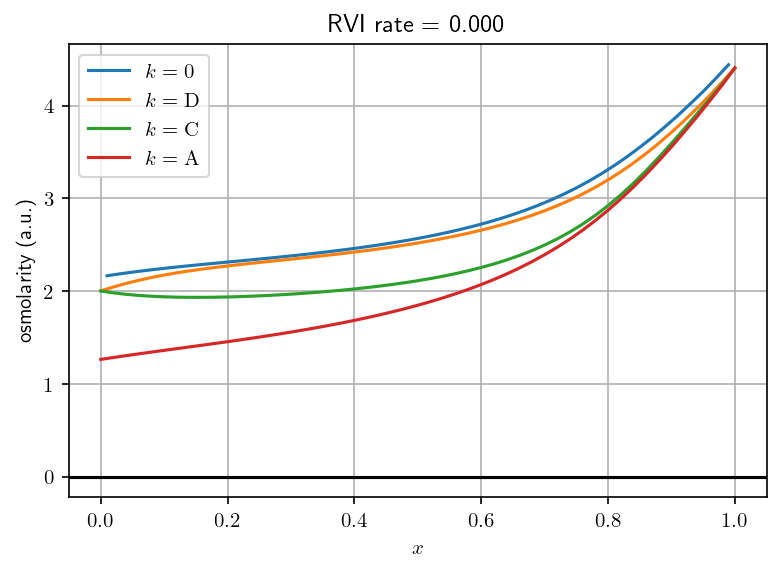

In [207]:
x = np.linspace(0,1,num=N+1)
x_avg = np.linspace(dx/2,1-dx/2,num=N)
fig, ax = plt.subplots()
compartments = ['0','\mathrm{D}','\mathrm{C}','\mathrm{A}']
plt.rcParams['text.usetex'] = True
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
for k in range(4):
    if k==0:
        ax.plot(x_avg,osm[0],label=r'$k={}$'.format(compartments[k]))
    else:
        ax.plot(x,osm[k],label=r'$k={}$'.format(compartments[k]))
ax.legend()
ax.set_title(r'RVI rate = {:.3f}'.format(rvi[0]))
plt.xlabel(r"$x$")
plt.ylabel(r"osmolarity (a.u.)")
plt.show

We can see that this doesn't match the osmolarity profile of the inner medulla in our model before the simplification.
First, we are neglecting diffusion; we can see that the dimensionless diffusion coefficients for the core is about $1.4\times 10^{-3}$ while the rests are $8.5\times 10^{-5}$.
This might contribute to the elevated osmolarity in the central core.
Second, the realistic values of water permeability are much lower than we previously expected; this causes large gaps between the tubular and core osmolarities.
Third, the decreasing in osmolarity in the collecting tubule means that there are more urea reabsorption than water.
But recall that we made an assumption that urea constitute the majority of the solutes in the collecting tubule.

Since reintroducing diffusion in the central core would change the structure of the model equation and there is nothing we can do about the water permeability, what we can try to do is to adjust the urea content.
We specify the urea and potassium input according to the real data.
Then, to make the initial osmolarity ($x=0$) match the ascending and collecting tubule, we add a constant solute flow without any transmural flux.
This way, the same numerical method would work.

### Numerical continuation
Now, we compute the steady states solution as we vary the RVI rate.

In [211]:
# y = np.vstack((y_init,np.zeros(6*N+7)))
# y = np.vstack((y[-1],np.zeros(6*N+7)))
# y[-1] = fsolve(res,y_init,args=(None,0,0.0005))
# y=y[:-10]
steps = 10
for n in range(steps):
    h = 0.0025
    while True:
        try:
            y_0 = fsolve(res,y[-1],args=(y[-2:],h))
            break
        except RuntimeWarning:
            h = h*0.8
            display(h)
    y = np.vstack((y,y_0))

S = y[:,:(N+1)]
U = y[:,(N+1):2*(N+1)]
q_D = y[:,2*(N+1):3*(N+1)]
q_C = y[:,3*(N+1):4*(N+1)]
q_A = y[:,4*(N+1):5*(N+1)]
q_out = y[:,5*(N+1):6*(N+1)]
dump = y[:,6*(N+1):]

<function matplotlib.pyplot.show(close=None, block=None)>

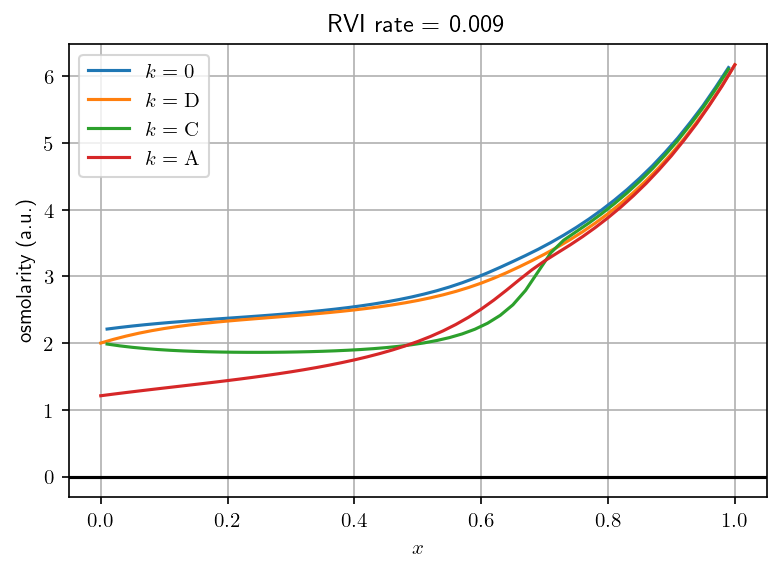

In [212]:
q_0 = q_out - q_C - q_A - q_D
iters = y.shape[0]
S_0 = np.zeros((iters,N))
U_0 = np.zeros((iters,N))
P_0 = np.zeros((iters,N))
P_C = np.zeros((iters,N+1))
osm_0 = np.zeros((iters,N))
avg_q_0 = np.zeros((iters,N))
avg_q_D = np.zeros((iters,N))
avg_q_A = np.zeros((iters,N))
avg_q_C = np.zeros((iters,N))
avg_S = np.zeros((iters,N))
avg_U = np.zeros((iters,N))
avg_P = np.zeros((iters,N))
avg_osm_D = np.zeros((iters,N))
avg_osm_A = np.zeros((iters,N))
avg_osm_C = np.zeros((iters,N))

for k in range(iters):
    S_0[k] = S[k,-1] - avg(S[k])
    U_0[k] = U[k,-1] - avg(U[k])
    P_0[k] = p_flow(0,dump[k])
    P_C[k] = p_flow('C',dump[k],False)
    avg_P[k] = p_flow('C',dump[k])
    osm_0[k] = (2*S_0[k]+U_0[k]+2*P_0[k])/avg(q_0[k])
    avg_q_0[k] = avg(q_0[k])
    avg_q_D[k] = avg(q_D[k])
    avg_q_A[k] = avg(q_A[k])
    avg_q_C[k] = avg(q_C[k])
    avg_S[k] = avg(S[k])
    avg_U[k] = avg(U[k])
    # avg_osm_D[k] = avg(osm_D[k])
    # avg_osm_A[k] = avg(osm_A[k])
    # avg_osm_C[k] = avg(osm_C[k])

avg_osm_D = 2*S_input/avg_q_D
avg_osm_A = 2*avg_S/avg_q_A
avg_osm_C = (avg_U+2*avg_P +N_input)/avg_q_C
osm_C = (U+2*P_C+N_input)/q_C
osm_D = 2*S_input/q_D
osm_A = 2*S/q_A
j_s = s_perm*(avg_S/avg_q_A - S_0/avg_q_0)
j_u = u_perm_val*(avg_U/avg_q_C - U_0/avg_q_0)
w_D = w_D_perm*(
        # (2*S_0 + U_0 + 2*P_0)/avg_q_0 - 2*S_input/avg_q_D
        osm_0 - avg_osm_D
    )
w_C = w_C_perm*(
        # (2*S_0 + U_0 + 2*P_0)/avg_q_0 - (avg_U + 2*avg_P)/avg_q_D
        osm_0 - avg_osm_C
    )

compartments = ['0','\mathrm{D}','\mathrm{C}','\mathrm{A}']
osm = [osm_0,osm_D,avg_osm_C,osm_A]
# osm = [avg_q_0,q_D,q_C,q_A]
q = [q_0,q_D,q_C,q_A]
x = np.linspace(0,1,num=N+1)
x_avg = np.linspace(dx/2,1-dx/2,num=N)
fig, ax = plt.subplots()
compartments = ['0','\mathrm{D}','\mathrm{C}','\mathrm{A}']
plt.rcParams['text.usetex'] = True
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
for k in range(4):
    if k==0 or k==2:
        ax.plot(x_avg,osm[k][-1],label=r'$k={}$'.format(compartments[k]))
    else:
        ax.plot(x,osm[k][-1],label=r'$k={}$'.format(compartments[k]))
# ax.plot(x_avg,avg_osm_A[-1],label=r'osm_A')
# ax.plot(x_avg,avg_osm_D[-1],label=r'osm_D')
# ax.plot(x_avg,avg_osm_C[-1],label=r'osm_C')
ax.legend()
ax.set_title(r'RVI rate = {:.3f}'.format(dump[-1,0]))
plt.xlabel(r"$x$")
plt.ylabel(r"osmolarity (a.u.)")
plt.show

In [179]:
# np.save('gap_ss_VRI.npy',y)

<function matplotlib.pyplot.show(close=None, block=None)>

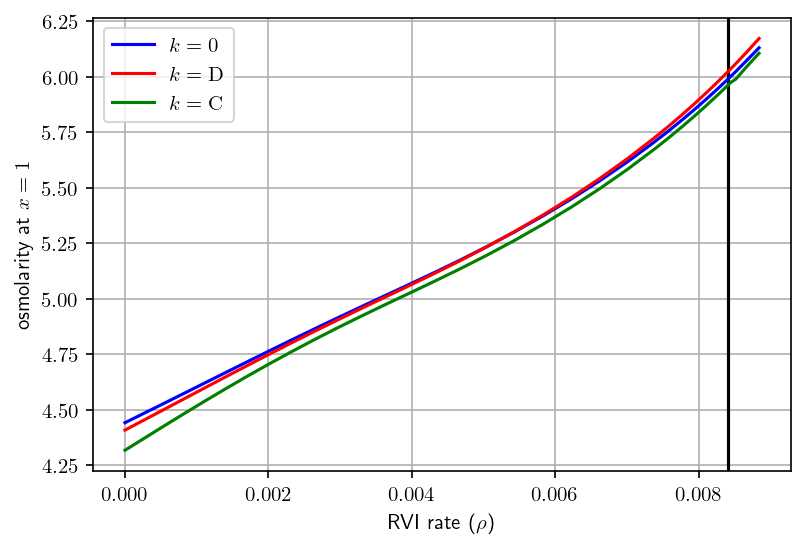

In [213]:
dumps = np.ravel(dump)
compartments = ['0','\mathrm{D}','\mathrm{C}']
colors = ['b','r','g']
plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots()
ax.grid(True, which='both')
ax.set_xlabel(r"RVI rate ($\rho$)")
ax.set_ylabel(r"osmolarity at $x=1$")
# ax.set_ylim(0,osm[0][0,-1]+1)
# ax.set_ylim(-1,13)
ax.axvline(x=P_input/u_frac,color='k')
for k in range(3):
    ax.plot(dumps, osm[k][:,-1], label=r'$k={}$'.format(compartments[k]),color=colors[k])
ax.legend()
# plt.xlabel(r"salt dump")
# plt.ylabel(r"osmolarity at $x=1$")
plt.show

In [78]:
# np.save('toy_RVI.npy',y)

<function matplotlib.pyplot.show(close=None, block=None)>

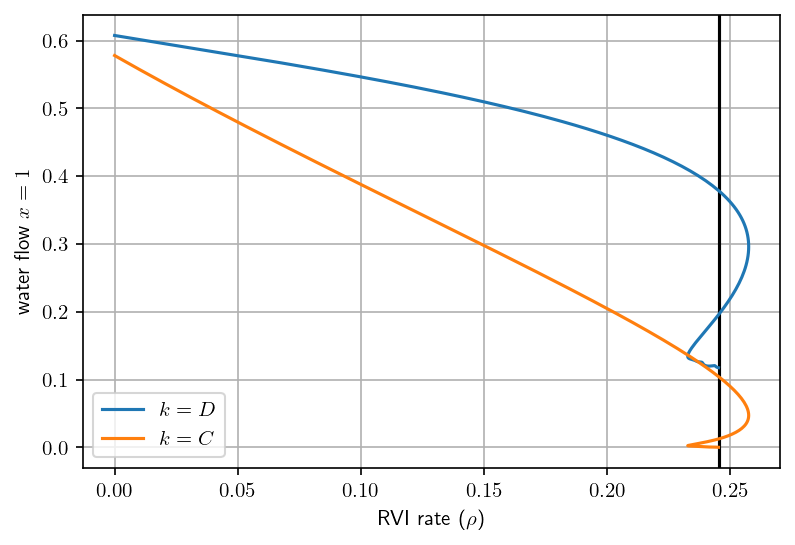

In [74]:
dumps = np.ravel(dump)
colors = ['b','r','g']
plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots()
ax.grid(True, which='both')
ax.set_xlabel(r"RVI rate ($\rho$)")
ax.set_ylabel(r"water flow $x=1$")
# ax.set_ylim(0,osm[0][0,-1]+1)
# ax.set_ylim(-1,13)
ax.axvline(x=P_input,color='k')
ax.plot(dumps, q[1][:,-1], label=r'$k=D$')
ax.plot(dumps, q[2][:,-1], label=r'$k=C$')
ax.legend()
# plt.xlabel(r"salt dump")
# plt.ylabel(r"osmolarity at $x=1$")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

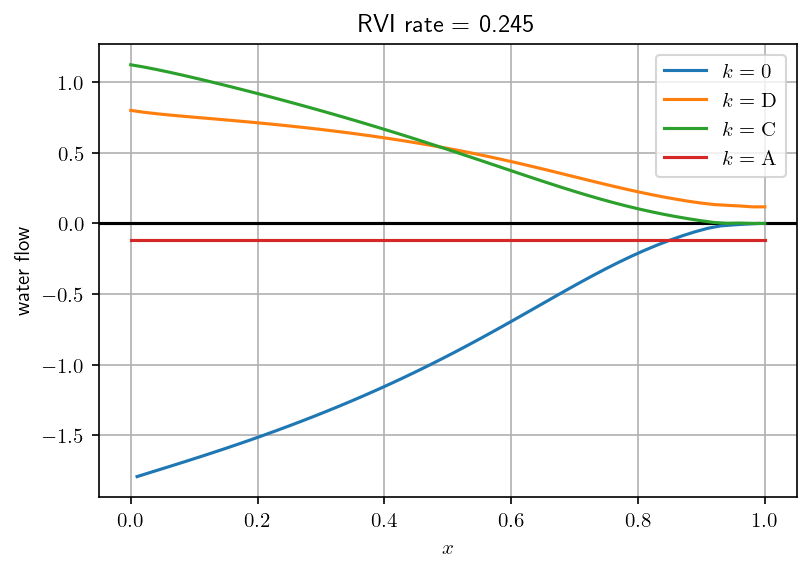

In [75]:
q = [avg_q_0,q_D,q_C,q_A]
x = np.linspace(0,1,num=N+1)
x_avg = np.linspace(dx/2,1-dx/2,num=N)
fig, ax = plt.subplots()
compartments = ['0','\mathrm{D}','\mathrm{C}','\mathrm{A}']
plt.rcParams['text.usetex'] = True
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
for k in range(4):
    if k==0:
        ax.plot(x_avg,q[0][-1],label=r'$k={}$'.format(compartments[k]))
    else:
        ax.plot(x,q[k][-1],label=r'$k={}$'.format(compartments[k]))
ax.legend()
ax.set_title(r'RVI rate = {:.3f}'.format(dump[-1,0]))
plt.xlabel(r"$x$")
plt.ylabel(r"water flow")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

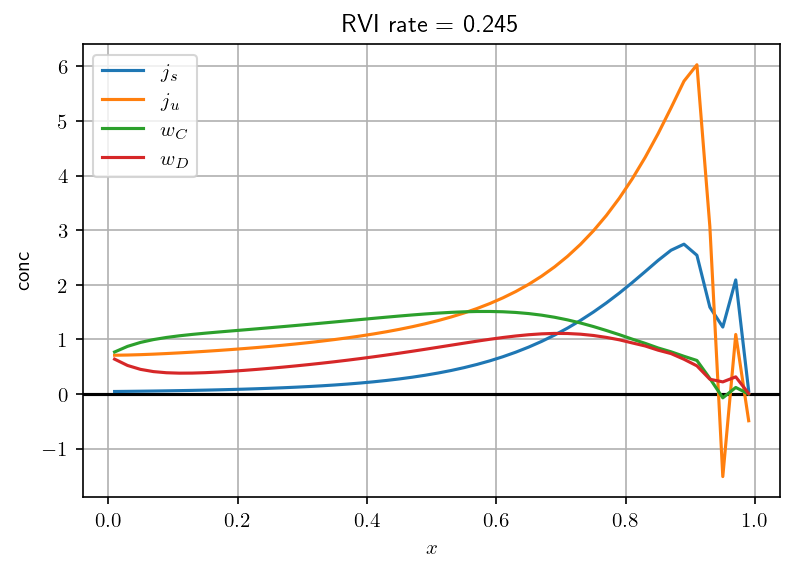

In [76]:
x_avg = np.linspace(dx/2,1-dx/2,num=N)
fig, ax = plt.subplots()
compartments = ['0','\mathrm{D}','\mathrm{C}','\mathrm{A}']
plt.rcParams['text.usetex'] = True
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.plot(x_avg,j_s[-1],label=r'$j_s$')
ax.plot(x_avg,j_u[-1],label=r'$j_u$')
ax.plot(x_avg,w_C[-1],label=r'$w_C$')
ax.plot(x_avg,w_D[-1],label=r'$w_D$')
ax.legend()
ax.set_title(r'RVI rate = {:.3f}'.format(dump[-1,0]))
plt.xlabel(r"$x$")
plt.ylabel(r"conc")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

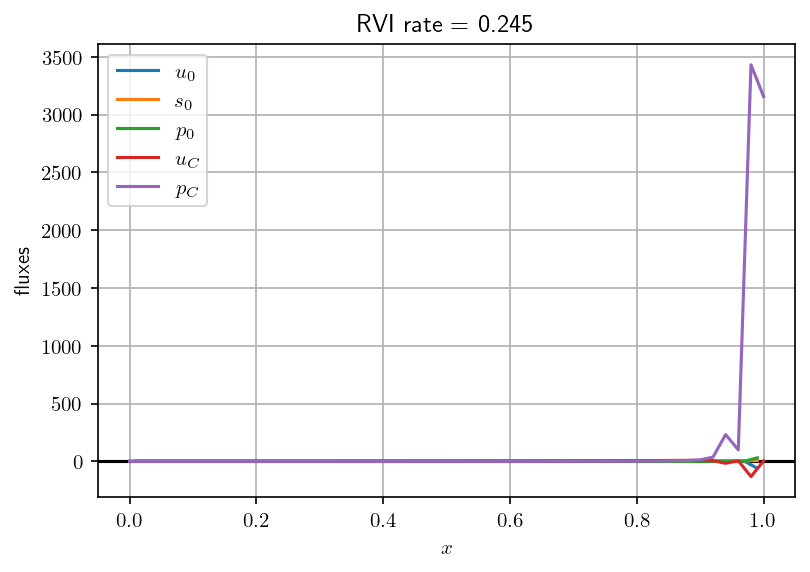

In [77]:
# x = np.linspace(0,1,num=N+1)
x_avg = np.linspace(dx/2,1-dx/2,num=N)
fig, ax = plt.subplots()
compartments = ['0','\mathrm{D}','\mathrm{C}','\mathrm{A}']
plt.rcParams['text.usetex'] = True
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.plot(x_avg,U_0[-1]/avg_q_0[-1],label=r'$u_0$')
ax.plot(x_avg,S_0[-1]/avg_q_0[-1],label=r'$s_0$')
ax.plot(x_avg,P_0[-1]/avg_q_0[-1],label=r'$p_0$')
ax.plot(x,U[-1]/q_C[-1],label=r'$u_C$')
ax.plot(x,P_C[-1]/q_C[-1],label=r'$p_C$')
ax.legend()
ax.set_title(r'RVI rate = {:.3f}'.format(dump[-1,0]))
plt.xlabel(r"$x$")
plt.ylabel(r"fluxes")
plt.show